In [28]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
#Read in all the words
words = open('/content/drive/MyDrive/dataSet_for_practice/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(min(len(w) for w in words))
print(words[:10])

32033
15
2
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [30]:
#build the vocabulary of the characters and mapping to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [31]:
#shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [32]:
#build the dataset
block_size = 8 #context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] #crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])



torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [33]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [34]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      if x.ndim == 2:
        dim = 0
      elif x.ndim == 3:
        dim = (0,1)
      xmean = x.mean(dim, keepdim=True) # batch mean
      xvar = x.var(dim, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]


# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []


# -----------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]


# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  def __init__(self, n):
    self.n = n

  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x

    return self.out

  def parameters(self):
    return []


# -----------------------------------------------------------------------------------------------
class Sequential:

  def __init__(self, layers):
    self.layers = layers

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

In [35]:
torch.manual_seed(42);# seed rng for reproducibility

In [36]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

#C = torch.randn((vocab_size, n_embd))
model = Sequential([
  Embedding(vocab_size, n_embd),
  FlattenConsecutive(2),Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # Modified this line
  FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(), # Modified this line
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

76579


In [37]:
ix = torch.randint(0, Xtr.shape[0], (4,)) #lets look at a batch of just 4 exmples
Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
logits = model(Xb)
print(logits.shape)
Xb

torch.Size([4, 27])


tensor([[ 0,  0,  0,  0,  0,  0, 12, 15],
        [ 0,  0,  0,  0, 16, 15, 18, 20],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, 12,  1, 25,  1, 14, 14]])

In [38]:
for layer in model.layers:
 print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNorm1d : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNorm1d : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNorm1d : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [39]:
# model.layers[0].out.shape #output of embedding layer

In [40]:
# model.layers[1].out.shape #output of Flatten layer

In [41]:
# model.layers[2].out.shape #output of Linear layer

In [42]:
# (torch.rand(4, 80) @ torch.rand(80, 200) + torch.rand(200)).shape

In [43]:
#(torch.rand(4, 4, 20) @ torch.rand(20, 200) + torch.rand(200)).shape

In [44]:
# a= list(range(20))[::2]
# b= list(range(20))[1::2]

# a,b

In [45]:
# e = torch.randn(4, 8, 10) #goal:want this to be (4,4,20)
# # The second slice should select elements to match the first slice's shape in dimension 1
# torch.cat([e[:, ::2, :], e[:, 1::2, :]], dim=2).shape # Concatenate along dimension 2 to get shape (4, 4, 20)

In [46]:
#same optimization
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  #Forward Pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  #backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  #update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  #track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())






      0/ 200000: 3.3162
  10000/ 200000: 2.0234
  20000/ 200000: 1.9302
  30000/ 200000: 2.7243
  40000/ 200000: 2.1421
  50000/ 200000: 1.8538
  60000/ 200000: 2.1315
  70000/ 200000: 1.8840
  80000/ 200000: 1.8958
  90000/ 200000: 1.9638
 100000/ 200000: 1.7545
 110000/ 200000: 1.8789
 120000/ 200000: 1.5655
 130000/ 200000: 1.9583
 140000/ 200000: 1.7172
 150000/ 200000: 1.7156
 160000/ 200000: 1.8353
 170000/ 200000: 1.6603
 180000/ 200000: 1.5071
 190000/ 200000: 2.1011


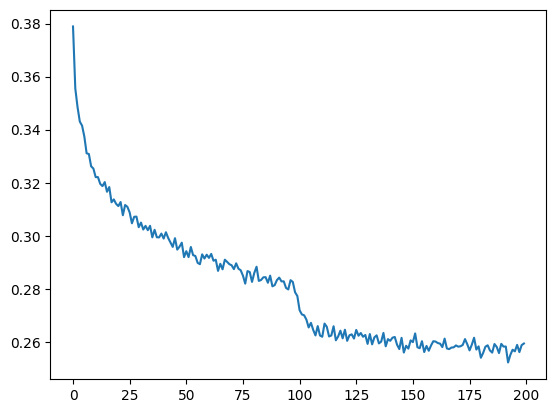

In [47]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [48]:
torch.arange(10).view(-1,5)

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [49]:
#put layers into eval mode (needed for batchmore especially)
for layer in model.layers:
  layer.training = False

In [50]:
#Evaluate the loss

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)

  loss = F.cross_entropy(logits, y)
  print(split, loss.item())


split_loss('train')
split_loss('val')

train 1.786982536315918
val 1.9893767833709717


In [51]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      logits = model(torch.tensor([context]))

      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

montay.
yazmine.
medhrith.
remma.
jendrie.
cailee.
seline.
mikaelle.
elionna.
arlemy.
kohlte.
cayshawn.
gihima.
stellie.
jennix.
terran.
brenden.
kyler.
meha.
kayshawn.


**for record : Performence log**

Before (3 character context + 200 hidden neuron):-

train 2.0621414184570312

val 2.109346389770508

8 characters:-

train 1.9251519441604614

val 2.03741455078125

bug fixed Now:-

train 1.9221560955047607

val 2.025007486343384

**mean(0)** computes the mean along the rows (across the batch), resulting in one mean per feature.

**mean(1)** computes the mean along the columns (across the features), resulting in one mean per sample.

Next time:

Why convolutions? Brief preview/hint

In [52]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [53]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

In [54]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
  logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])